In [26]:
import pandas as pd
import numpy as np
import sys
import os
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter

# Loading the data

In [27]:
from src.dataLoading import loadNormalMNIST, loadChineseMNIST

samplesPerClass = 1000  # same number of samples per class as the whole chinese MNIST data

mnistVectors, mnistImages, mnistLabels = loadNormalMNIST()

chineseVectors, chineseImages, chineseLabels = loadChineseMNIST()


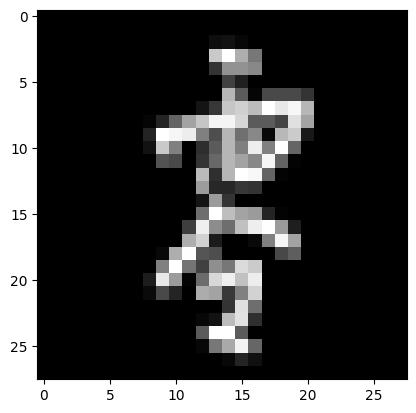

In [28]:
img = chineseImages[random.randint(0, len(chineseImages))]
plt.imshow(img, cmap='gray')

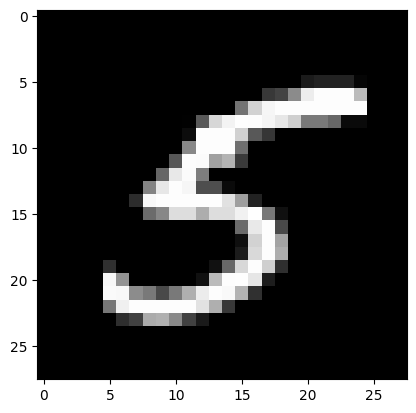

In [29]:
img =mnistImages[random.randint(0, len(mnistImages))]
plt.imshow(img, cmap='gray')

## Feature extraction: train-test split

In [30]:
from sklearn.model_selection import train_test_split

"""
names = ['original chinese', 'smaller chinese', 'mnist']
short_names = ['_og_ch', '_sm_ch', '_mnist']
#data = [allChineseImages, smallerChineseImages, mnistImages]
data = [chineseImages, augChineseImages, mnistImages]

labels = [chineselabels, augChineselabels, mnistLabels]

for i in range(len(names)):
    locals()['X_train'+short_names[i]], locals()['X_test'+short_names[i]], locals()['Y_train'+short_names[i]], locals()['Y_test'+short_names[i]] = train_test_split(data[i], labels[i], train_size=0.8, random_state=42)
    print('X_train'+short_names[i])

data_train = [X_train_og_ch, X_train_sm_ch, X_train_mnist]
labels_train = [Y_train_og_ch, Y_train_sm_ch, Y_train_mnist]

data_test = [X_test_og_ch, X_test_sm_ch, X_test_mnist]
labels_test = [Y_test_og_ch, Y_test_sm_ch, Y_test_mnist]
"""
names = ['smaller chinese', 'mnist']
short_names = ['_chinese', '_mnist']
#data = [allChineseImages, smallerChineseImages, mnistImages]
data_vect = [chineseVectors, mnistVectors]
data_images = [chineseImages, mnistImages]
labels = [chineseLabels, mnistLabels]

for i in range(len(names)):
    locals()['X_vec_train'+short_names[i]], locals()['X_vec_test'+short_names[i]], locals()['Y_train'+short_names[i]], locals()['Y_test'+short_names[i]] = train_test_split(data_vect[i], labels[i], train_size=0.8, random_state=42)
    locals()['X_img_train'+short_names[i]], locals()['X_img_test'+short_names[i]], locals()['Y_train'+short_names[i]], locals()['Y_test'+short_names[i]] = train_test_split(data_images[i], labels[i], train_size=0.8, random_state=42)

    print('X_train'+short_names[i])

data_vec_train = [X_vec_train_chinese, X_vec_train_mnist]
data_img_train = [X_img_train_chinese, X_img_train_mnist]

labels_train = [Y_train_chinese, Y_train_mnist]

data_vec_test = [X_vec_test_chinese, X_vec_test_mnist]
data_img_test = [X_img_test_chinese, X_img_test_mnist]

labels_test = [Y_test_chinese, Y_test_mnist]


X_train_chinese
X_train_mnist


## PCA
Parameter tunning missing

In [31]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=20)


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

for i in range(len(names)):
    print(names[i])
    X_train = sklearn_pca.fit_transform(data_vec_train[i])
    X_test = sklearn_pca.transform(data_vec_test[i])

    svm = SVC().fit(X_train, labels_train[i])

    predictions = svm.predict(X_test)
    accuracy = accuracy_score(labels_test[i], predictions)
    print("acc:", accuracy)


smaller chinese
acc: 0.9895
mnist
acc: 0.955


## HAND-CRAFTED FEARURES 

## Mixture of Gaussians

In [33]:
#IGNORE GRID SEARCH
"""
def gmm_bic_score(estimator, X):
    
    #Callable to pass to GridSearchCV that will use the BIC score
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(smallerChineseImages)
"""

'\ndef gmm_bic_score(estimator, X):\n    \n    #Callable to pass to GridSearchCV that will use the BIC score\n    # Make it negative since GridSearchCV expects a score to maximize\n    return -estimator.bic(X)\n\n\nparam_grid = {\n    "n_components": range(1, 7),\n    "covariance_type": ["spherical", "tied", "diag", "full"],\n}\ngrid_search = GridSearchCV(\n    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score\n)\ngrid_search.fit(smallerChineseImages)\n'

In [34]:
from statistics import mode
from sklearn.mixture import GaussianMixture
n_components = 10
# Vector data
def mix_gauss(x_train, x_test, n_components=10):
    GM = GaussianMixture(n_components = n_components)
    GM.fit(x_train) 
    # This is enough for the feature
    X_train_GM = GM.predict(x_train)
    X_test_GM = GM.predict(x_test)

    return X_train_GM, X_test_GM

    # This will be to plot the features
"""
    label_gauss = []
    for j in range(n_components):
        count = np.where(X_train_GM == j)[0]
        gauss1 = np.zeros(len(count))
        for i in range(len(count)):
            ii = count[i]
            gauss1[i] = int(labels[ii])

        label_gauss.append(str(mode(gauss1)))
    print(label_gauss)

"""

'\n    label_gauss = []\n    for j in range(n_components):\n        count = np.where(X_train_GM == j)[0]\n        gauss1 = np.zeros(len(count))\n        for i in range(len(count)):\n            ii = count[i]\n            gauss1[i] = int(labels[ii])\n\n        label_gauss.append(str(mode(gauss1)))\n    print(label_gauss)\n\n'

## KMeans

In [35]:
from sklearn.cluster import KMeans

n_components = 10
# Vector data
def K_means(x_train, x_test, n_components=10):
    kmeans = KMeans(n_clusters=n_components)

    k = 1
    X_train_KNN = kmeans.fit_transform(x_train)
    X_test_KNN = kmeans.transform(x_test)
    #closest cluster will be another feature 
    closest_cluster = np.zeros(len(X_train_KNN[:,1]))
    for i in range(len(X_train_KNN[:,1])):
        min = np.min(X_train_KNN[i,:])
        index = np.where(X_train_KNN[i,:] == min)[0]
        closest_cluster[i] = int(index[0])
    X_train = (closest_cluster)

    closest_cluster = np.zeros(len(X_test_KNN[:,1]))
    for i in range(len(X_test_KNN[:,1])):
        min = np.min(X_test_KNN[i,:])
        index = np.where(X_test_KNN[i,:] == min)[0]
        closest_cluster[i] = int(index[0])
    X_test = closest_cluster

    return X_train, X_test


## SUM OF EDGES 
- Laplacian and Sobel

In [36]:
#Laplacian,  same for testing
def edges_laplace(data_Images):
    edges = np.zeros(len(data_Images)) 
    for ii in range(len(data_Images)):
        img = data_Images[ii].astype('uint8')
        lapl = cv2.Laplacian(img, ddepth=-1) # ddepth -1: output same depth as source
        edges[ii] = np.sum(lapl)
    #plt.imshow(lapl, cmap='gray')
    return edges


In [37]:
# Sobel
## WORKS WORSE THAN LAPLACE
from scipy.ndimage import sobel

def edges_sobel(data_Images):
    edges = np.zeros(len(data_Images)) 
    for ii in range(len(data_Images)):
        img = data_Images[ii]
        ss = sobel(img)
        edges[ii] = np.sum(ss)
    #plt.imshow(ss, cmap='gray')
    return edges



## Mean Brigtness


In [38]:

# Vector data
def mean_brightness(data):
    brigthness = np.zeros(len(data[:,1])) 
    for ii in range(len(data[:,1])):
        brigthness[ii] = np.sum(data[ii,:])/len(data[ii,:])
    return brigthness
    

## Numbert of Contours

In [39]:
def n_Contours(data): 
    #Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity
    ## so a 0 should have 2 contours, an 8, 3?
#IMAGE DATA
    nu_lines = np.zeros(len(data)) 
    for ii in range(len(data)):
        img = data[ii].astype('uint8')
        img_bin = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # the threshold needs to be tuned

        num_labels, labels = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        nu_lines[ii] = np.shape(num_labels)[0]

    return nu_lines


## Number of circles Hough transform

The circles dont help at all :(

In [40]:
def n_Circles(data):
    #IMAGE DATA
    circles = np.zeros(len(data))
    for ii in range(len(data)):
        img = data[ii].astype('uint8')
        img_bin = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # the threshold needs to be tuned
        try:
            circles[ii] = len(cv2.HoughCircles(img_bin,cv2.HOUGH_GRADIENT_ALT, dp=1.5 , minDist = 1,
                            param1=100,param2=0, minRadius=0,maxRadius=0)) 
        except:
            continue
    return circles


# Ratio Height/Width

In [41]:
# get bounds of white pixels
def heigh_width(data):
    #IMAGE DATA
    ratio = np.zeros(len(data))
    for ii in range(len(data)):
        img = data[ii].astype('uint8')
        img_bin = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # the threshold needs to be tuned
        white = np.where(img_bin == 255)
        xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
        ratio[ii] = (ymax-ymin)/(xmax-xmin)
        
    return ratio

## Ratio of center column/row of bounding box

In [42]:
# get bounds of white pixels
def center_col_row(data):
    #IMAGE DATA
    ratios = np.zeros(len(data))
    for ii in range(len(data)):
        img = data[ii].astype('uint8')
        img_bin = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # the threshold needs to be tuned
        white = np.where(img_bin != 0)
        xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
        yrange, xrange = ymax-ymin, xmax-xmin

        x_center = int(np.round((xmax+xmin)/2))
        y_center = int(np.round((ymax+ymin)/2))

        if xrange%2 != 0:
            x_sum = np.sum(img_bin[x_center, :]) + np.sum(img_bin[x_center-1, :])
            x_sum /= 2
        else: 
            x_sum = np.sum(img_bin[x_center,:])
        if yrange%2 != 0:
            y_sum = np.sum(img_bin[:,y_center]) + np.sum(img_bin[:, y_center-1])
            y_sum /= 2
        else: 
            y_sum = np.sum(img_bin[: ,y_center])
        
        if y_sum >= x_sum:
            ratios[ii] = 1
        else:
            ratios[ii] = 0
    """
    plt.imshow(img_bin)
    plt.axvline(x_center)
    plt.axhline(y_center)
    print(xmin, ymin, xmax, ymax)
    print(x_center, y_center)
    """
    return ratios



In [43]:
center_col_row(X_img_train_mnist)

array([1., 1., 1., ..., 1., 1., 1.])

## (White & Black) Island Counting

In [44]:
def islandCounter(data):
    length = len(data)
    whiteIslandsArray = np.zeros(length)
    blackIslandsArray = np.zeros(length)
    for ii in range(length):
        image = data[ii].astype('uint8')

        # get the external edges (white object on black background)
        ret, thresholdedIm = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _  = cv2.findContours(thresholdedIm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # get the number of white islands (just use the contours, this works fine)
        whiteIslands = np.zeros_like(thresholdedIm)
        numWhiteIslands = len(contours)
        whiteIslandsArray[ii] = numWhiteIslands


        # Draw contour onto blank mask
        mask = np.zeros_like(thresholdedIm)
        cv2.fillPoly(mask, pts=contours, color=(255, 255, 255))
        # use XOR between the mask and the thresholded image to find the black islands
        blackIslands = cv2.bitwise_xor(thresholdedIm, mask)

        # get the number of black islands
        blackContours, _ = cv2.findContours(blackIslands, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        numBlackIslands = len(blackContours)
        blackIslandsArray[ii] = numBlackIslands

    return whiteIslandsArray, blackIslandsArray



## TRY ALL AT ONCE

In [45]:
X_train_sets = []
X_test_sets = []

for d in range(len(names)):
        print(names[d])
        n_components = 10
        # I will append each feature
        X_train = []
        X_test = []

        MG_train, MG_test = mix_gauss(data_vec_train[d], data_vec_test[d], n_components)
        X_train.append(MG_train)
        X_test.append(MG_test)

        KM_train, KM_test = K_means(data_vec_train[d], data_vec_test[d], n_components)
        X_train.append(KM_train)
        X_test.append(KM_test)

        X_train.append(edges_laplace(data_img_train[d]))
        X_test.append(edges_laplace(data_img_test[d]))

        X_train.append(mean_brightness(data_vec_train[d]))
        X_test.append(mean_brightness(data_vec_test[d]))

        X_train.append(n_Contours(data_img_train[d]))
        X_test.append(n_Contours(data_img_test[d]))

        #X_train.append(n_Circles(data_img_train[d]))
        #X_test.append(n_Circles(data_img_test[d]))

        X_train.append(heigh_width(data_img_train[d]))
        X_test.append(heigh_width(data_img_test[d]))

        X_train.append(center_col_row(data_img_train[d]))
        X_test.append(center_col_row(data_img_test[d]))
        
        trainWhites, trainBlacks = islandCounter(data_img_train[d])
        X_train.append(trainWhites)
        X_train.append(trainBlacks)
        testWhites, testBlacks = islandCounter(data_img_test[d])
        X_test.append(testWhites)
        X_test.append(testBlacks)

        # transpose the results here
        X_train_sets.append(np.asarray(X_train).T)
        X_test_sets.append(np.asarray(X_test).T) 

smaller chinese


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


mnist


c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [46]:
print(len(X_train_sets)) # how many X train sets
print(len(X_train_sets[0])) # how many images in that
print(len(X_train_sets[0][0])) # how many features per image

2
8000
9


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for d in range(len(names)):
        print(names[d])
        knn = KNeighborsClassifier(n_neighbors=3).fit(X_train_sets[d], labels_train[d])
        predictions = knn.predict(X_test_sets[d])
        accuracy = accuracy_score(labels_test[d], predictions)
        print("acc:", accuracy)


smaller chinese
acc: 0.4635
mnist
acc: 0.2715


In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

for d in range(len(names)):
        print(names[d])
        svm = SVC().fit(X_train_sets[d], labels_train[d])
        predictions = svm.predict(X_test_sets[d])
        accuracy = accuracy_score(labels_test[d], predictions)
        print("acc:", accuracy)


smaller chinese
acc: 0.3075
mnist
acc: 0.302


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


for d in range(len(names)):
        print(names[d])

        clf = RandomForestClassifier(n_estimators=200 ,max_depth=10, random_state=0)
        clf.fit(X_train_sets[d], labels_train[d])
        predictions = clf.predict(X_test_sets[d])
        accuracy = accuracy_score(labels_test[d], predictions)
        print("acc:", accuracy)

smaller chinese
acc: 0.9285
mnist
acc: 0.765


## without islands
KNN
    smaller chinese
    acc: 0.435
    mnist
    acc: 0.2815

SVM
    smaller chinese
    acc: 0.3065
    mnist
    acc: 0.2925

Random Forest
    smaller chinese
    acc: 0.8625
    mnist
    acc: 0.749

## with islands
KNN
    smaller chinese
    acc: 0.4525
    mnist
    acc: 0.2775

SVM
    smaller chinese
    acc: 0.3075
    mnist
    acc: 0.2925
    
Random Forest
   smaller chinese
    acc: 0.874   (i saw this go over 0.91)
    mnist
    acc: 0.769